# Modeling - Advanced RAG

This notebook include testing of some models until we defined the final one.

Let's remember the strategies:

1. Extractive QA: The answer is a span of text from the context.
    1. In this case we can possible use some kind of retriever in the query and use the model as an extractor for the context. 
    2. The problem with this (at this point) is don't know how good each topic of the dataset is represented in the dataset.
2. Open Generative QA: The answer generated by one of the retrieved options.
    1. Using more complexity (in terms of memory and time) we can use a model to generate the answer. We rely in some pre-trained model knowledge better approach some queries variants.
    2. More complexity, more inference time, possible need GPU and not can generate no safety answer (considering the dataset is composed only by true/safe answers).
3. Generative QA: The answer is a free text.
    1. The same as the open generative QA but not always rely in the retrieved options.


## Libs and Variables

In [1]:
import logging
import random
import re
import warnings

import numpy as np
import pandas as pd
import torch
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DataFrameLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_core.prompts.chat import ChatPromptTemplate
from metrics import compute_metrics
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from langchain_experimental.text_splitter import SemanticChunker
import tiktoken

# Remove pandas warning from Sentence Transformers lib
warnings.simplefilter(action="ignore", category=FutureWarning)

# Ollama http logs
logging.getLogger("httpx").setLevel(logging.WARNING)

clean_repeated_ws = lambda text: re.sub(r"\s+", " ", text).strip()

d:\Documents\Git\venvs\ml_base_310\lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/sentence-t5-base


In [2]:
def seed_all():
    """
    Seed all the random number generators to ensure reproducibility.

    This function sets the seed for the Python built-in random module and the NumPy random module to 42.
    This ensures that any random operations performed using these modules will produce the same results
    each time the code is run.
    """
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)


seed_all()

In [3]:
DATA_PATH = "../data/data.csv"

## Load data

In [4]:
data = pd.read_csv(DATA_PATH)

data["question"] = data["question"].astype(str)
data["answer"] = data["answer"].astype(str)

data["question"] = data["question"].apply(clean_repeated_ws)
data["answer"] = data["answer"].apply(clean_repeated_ws)

In [5]:
data.head(5).style

,question,answer
0,What is (are) Glaucoma ?,"Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more. See a glossary of glaucoma terms."
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 million nerve fibers. It connects the retina to the brain.
2,What is (are) Glaucoma ?,"Open-angle glaucoma is the most common form of glaucoma. In the normal eye, the clear fluid leaves the anterior chamber at the open angle where the cornea and iris meet. When the fluid reaches the angle, it flows through a spongy meshwork, like a drain, and leaves the eye. Sometimes, when the fluid reaches the angle, it passes too slowly through the meshwork drain, causing the pressure inside the eye to build. If the pressure damages the optic nerve, open-angle glaucoma -- and vision loss -- may result."
3,Who is at risk for Glaucoma? ?,"Anyone can develop glaucoma. Some people are at higher risk than others. They include - African-Americans over age 40 - everyone over age 60, especially Hispanics/Latinos - people with a family history of glaucoma. African-Americans over age 40 everyone over age 60, especially Hispanics/Latinos people with a family history of glaucoma. See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more."
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent glaucoma. However, studies have shown that the early detection and treatment of glaucoma, before it causes major vision loss, is the best way to control the disease. So, if you fall into one of the higher risk groups for the disease, make sure to have a comprehensive dilated eye exam at least once every one to two years. Get tips on finding an eye care professional. Learn what a comprehensive dilated eye exam involves."


## Data split

In [6]:
# split train test val (90-5-5)
train, test = train_test_split(data, test_size=0.9, random_state=42, shuffle=True)
val, test = train_test_split(test, test_size=0.5, random_state=42, shuffle=True)

# reducing test
test = test.sample(frac=0.025, random_state=42)

## RAG

### Vector Database

In [7]:
tokenizer = tiktoken.get_encoding("o200k_base")

embeddings_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embed = HuggingFaceEmbeddings(model_name=embeddings_model_name)


# Semantic split to avoid bigger chunks in generation
def semantic_chunk(answer):
    if len(tokenizer.encode(answer)) > 512:
        text_splitter = SemanticChunker(embed)  # near to 512
        return [i.page_content for i in text_splitter.create_documents([answer])]
    else:
        return [answer]

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


In [8]:
# Generating chunks for train dataset, let's keep other columns as metadata for this project.
train["answer_chunks"] = train["answer"].apply(semantic_chunk)

train = train.explode("answer_chunks")

In [9]:
train

,question,answer,answer_chunks
4873,What are the symptoms of Juvenile osteoporosis ?,What are the signs and symptoms of Juvenile os...,What are the signs and symptoms of Juvenile os...
13087,How many people are affected by erythrokeratod...,EKVP is a rare disorder; its prevalence is unk...,EKVP is a rare disorder; its prevalence is unk...
8038,How to diagnose Parasites - Loiasis ?,In people who have been bitten by the flies th...,In people who have been bitten by the flies th...
12342,How many people are affected by Lennox-Gastaut...,Lennox-Gastaut syndrome affects an estimated 1...,Lennox-Gastaut syndrome affects an estimated 1...
3335,What is (are) Bilateral frontal polymicrogyria ?,Bilateral frontal polymicrogyria is one of the...,Bilateral frontal polymicrogyria is one of the...
...,...,...,...
860,What are the stages of Uterine Sarcoma ?,Key Points - After uterine sarcoma has been di...,"For a regional lymphadenectomy, some of the ly..."
15795,How to diagnose Cirrhosis ?,A health care provider usually diagnoses cirrh...,A health care provider usually diagnoses cirrh...
15795,How to diagnose Cirrhosis ?,A health care provider usually diagnoses cirrh...,Blood test.
15795,How to diagnose Cirrhosis ?,A health care provider usually diagnoses cirrh...,A blood test involves drawing blood at a healt...


In [10]:
loader_question = DataFrameLoader(train, page_content_column="question")
loader_answer = DataFrameLoader(train, page_content_column="answer")

docs_question = loader_question.load()
docs_answer = loader_answer.load()

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=128, chunk_overlap=32)

# Important to remember, split_docs in loader split only the 'page_content' column.
splits_question = text_splitter.split_documents(docs_question)
splits_answer = text_splitter.split_documents(docs_answer)

In [12]:
embeddings_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embed = HuggingFaceEmbeddings(model_name=embeddings_model_name)


vectorstore_questions = FAISS.from_documents(documents=splits_question, embedding=embed)
vectorstore_answers = FAISS.from_documents(documents=splits_answer, embedding=embed)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:faiss.loader:Loading faiss with AVX512 support.
INFO:faiss.loader:Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.


In [13]:
# LLM
llm = ChatOllama(model="llama3.2:1b", temperature=0)

# Prompt Rag Generation
system_message_rag = """
You are a medical assistant AI Bot oriented by document search.
You answer need to be based on the provivided context, you don't need to specify how you answer to the user.
If you don't have certain about the answer, please let the user know and don't try to guess.
"""

prompt_rag = """
Answer the provided question based on the retrieved documments.

Question:
{query}

Context:
{context}

Answer:
"""

# Prompt Open Generation
system_message_open = """
You are a medical assistant AI Bot.
If you don't have certain about the answer, please let the user know and don't try to guess.
"""

prompt = """
Answer the provided question based on the retrieved documments.

Question:
{query}

Answer:
"""


template_rag = ChatPromptTemplate(
    [("system", system_message_rag), ("human", prompt_rag)]
)
template_open = ChatPromptTemplate([("system", system_message_open), ("human", prompt)])

### Define the flow

In [14]:
from langgraph.graph import START, END, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


class State(TypedDict):
    query: str
    context: List[Document]
    answer: str
    threshold_question: float
    threshold_answer: float
    flow: List[str]


def question_db_retrieval(state: State):

    retrieved_docs = vectorstore_questions.similarity_search_with_relevance_scores(
        state["query"], k=3
    )

    filtered_retrieved = list(
        filter(lambda x: x[1] > state["threshold_question"], retrieved_docs)
    )

    return {"context": filtered_retrieved, "flow": ["question_db_retrieval"]}


def question_db_retrieval_router(state: State):
    if len(state["context"]) == 0:
        return "answer_db_retrieval"
    return "generation"


def answer_db_retrieval(state: State):

    retrieved_docs = vectorstore_answers.similarity_search_with_relevance_scores(
        state["query"], k=3
    )

    filtered_retrieved = list(
        filter(lambda x: x[1] > state["threshold_answer"], retrieved_docs)
    )

    return {
        "context": filtered_retrieved,
        "flow": state["flow"] + ["answer_db_retrieval"],
    }


def answer_db_retrieval_router(state: State):
    if len(state["context"]) == 0:
        return "open_generation"
    return "generation"


def generation(state: State):

    docs_content = "\n\n".join(
        doc[0].metadata["answer_chunks"] for doc in state["context"]
    )

    messages = template_rag.invoke({"query": state["query"], "context": docs_content})

    response = llm.invoke(messages)

    return {"answer": response, "flow": state["flow"] + ["generation"]}


def open_generation(state: State):

    messages = template_open.invoke({"query": state["query"]})

    response = llm.invoke(messages)

    state["flow"].append("open_generation")

    return {"answer": response, "flow": state["flow"]}


graph_builder = StateGraph(State)

graph_builder.add_node("question_db_retrieval", question_db_retrieval)
graph_builder.add_node("answer_db_retrieval", answer_db_retrieval)
graph_builder.add_node("generation", generation)
graph_builder.add_node("open_generation", open_generation)

# Edges
graph_builder.add_edge(START, "question_db_retrieval")

graph_builder.add_conditional_edges(
    "question_db_retrieval",
    question_db_retrieval_router,
    path_map={"answer_db_retrieval": "answer_db_retrieval", "generation": "generation"},
)
graph_builder.add_conditional_edges(
    "answer_db_retrieval",
    answer_db_retrieval_router,
    path_map={"generation": "generation", "open_generation": "open_generation"},
)

graph_builder.add_edge("generation", END)
graph_builder.add_edge("open_generation", END)

graph = graph_builder.compile()

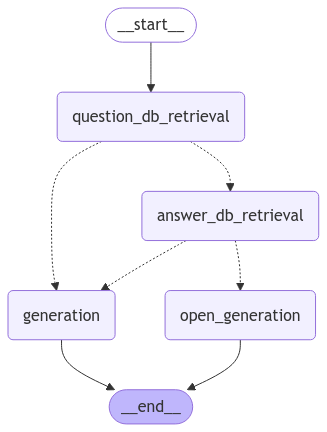

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [16]:
question = train.iloc[0].question
answer = train.iloc[0].answer

print(f"Question: {question}\n")
print(f"True Answer: {answer}\n")

inference = graph.invoke(
    {"query": question, "threshold_question": 0.7, "threshold_answer": 0.5}
)

print(f"Model Answer: \n{inference['answer'].content}")

Question: What are the symptoms of Juvenile osteoporosis ?

True Answer: What are the signs and symptoms of Juvenile osteoporosis? The Human Phenotype Ontology provides the following list of signs and symptoms for Juvenile osteoporosis. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Bone pain 90% Recurrent fractures 90% Reduced bone mineral density 90% Gait disturbance 50% Kyphosis 7.5% Autosomal recessive inheritance - Low serum calcitriol (1,25-dihydroxycholecalciferol) - Osteoporosis - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate 

In [17]:
inference

{'query': 'What are the symptoms of Juvenile osteoporosis ?',
 'context': [(Document(metadata={'answer': 'What are the signs and symptoms of Juvenile osteoporosis? The Human Phenotype Ontology provides the following list of signs and symptoms for Juvenile osteoporosis. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Bone pain 90% Recurrent fractures 90% Reduced bone mineral density 90% Gait disturbance 50% Kyphosis 7.5% Autosomal recessive inheritance - Low serum calcitriol (1,25-dihydroxycholecalciferol) - Osteoporosis - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is us

## Evaluation

In [18]:
for i, row in tqdm(test.iterrows(), total=test.shape[0]):
    question = row.question
    answer = row.answer

    inference = graph.invoke(
        {"query": question, "threshold_question": 0.7, "threshold_answer": 0.5}
    )

    test.loc[i, "model_answer"] = inference["answer"].content
    test.loc[i, "generation_duration"] = inference["answer"].response_metadata[
        "total_duration"
    ]
    test.loc[i, "generation_n_tokens"] = inference["answer"].response_metadata[
        "eval_count"
    ]

  0%|          | 0/185 [00:00<?, ?it/s]

In [19]:
metrics = compute_metrics(
    test["model_answer"].tolist(), [[i] for i in test["answer"].tolist()]
)


metrics["mean_generation_duration"] = test["generation_duration"].mean() * 1e-9


metrics["mean_generation_n_tokens"] = test["generation_n_tokens"].mean()


metrics["bleu_score"] = metrics["bleu"]["bleu"]


metrics["bertscore_precision"] = np.mean(metrics["bertscore"]["precision"])

metrics["bertscore_recall"] = np.mean(metrics["bertscore"]["recall"])


metrics["bertscore_f1"] = np.mean(metrics["bertscore"]["f1"])

metrics["st_similarities"] = np.mean(metrics["st_similarities"])


del metrics["bleu"]


del metrics["bertscore"]

In [20]:
metrics

{'st_similarities': np.float32(0.9066196),
 'mean_generation_duration': np.float64(2.181169461081081),
 'mean_generation_n_tokens': np.float64(122.70270270270271),
 'bleu_score': 0.01691569167168544,
 'bertscore_precision': np.float64(0.7808726375167434),
 'bertscore_recall': np.float64(0.7505342383642455),
 'bertscore_f1': np.float64(0.7637633748956629)}

In [21]:
metrics_csv = pd.DataFrame(metrics, index=[1])

In [22]:
metrics_csv

,st_similarities,mean_generation_duration,mean_generation_n_tokens,bleu_score,bertscore_precision,bertscore_recall,bertscore_f1
1,0.90662,2.181169,122.702703,0.016916,0.780873,0.750534,0.763763


In [23]:
metrics_csv.to_csv(
    f"../results/metrics_advanced_rag_{llm.model.replace(':','_')}.csv", index=False
)

In [24]:
test.to_csv(
    f"../results/test_advanced_rag_{llm.model.replace(':','_')}.csv", index=False
)

In [25]:
test.head(5).style

,question,answer,model_answer,generation_duration,generation_n_tokens
6890,What are the treatments for Filippi syndrome ?,"How might Filippi syndrome be treated? The treatment of Filippi syndrome is directed toward the specific symptoms that are apparent in each individual. Treatment may require the coordinated efforts of a team of medical professionals who may need to systematically and comprehensively plan an affected child's treatment. These professionals may include pediatricians; physicians who specialize in disorders of the skeleton, joints, muscles, and related tissues (orthopedists); and/or other health care professionals. In some affected individuals, treatment may include surgical repair of certain skeletal or other abnormalities associated with the disorder. The surgical procedures performed will depend upon the severity of the abnormalities, their associated symptoms, and other factors.","I can provide information on Filippelli syndrome (also known as Filippelli's disease or congenital insufficiency of the lower esophageal sphincter), but I must clarify that it is not a commonly recognized medical condition. However, I found some information on a related condition called ""Congenital Insufficiency of the Lower Esophageal Sphincter"" (CILES) or ""Filippelli's disease"", which is a rare congenital disorder characterized by an abnormal opening between the esophagus and stomach. If you're looking for treatment options, I couldn't find any specific treatments mentioned in medical literature. It's essential to consult with a healthcare professional for personalized advice and diagnosis. Please note that Filippelli syndrome is not a well-documented condition, and more research is needed to provide accurate information on its treatment. If you have any further questions or concerns, feel free to ask!",3372084600.000000,188.000000
2666,What is (are) Kluver Bucy syndrome ?,"Kluver Bucy syndrome is a rare behavioral impairment characterized by inappropriate sexual behaviors and mouthing of objects. Other signs and symptoms, include a diminished ability to visually recognize objects, loss of normal fear and anger responses, memory loss, distractibility, seizures, and dementia. It is associated with damage to the anterior temporal lobes of the brain. Cases have been reported in association with herpes encephalitis and head trauma. Treatment is symptomatic and may include the use of psychotropic medications.","I can provide information on Kluver-Bucy syndrome based on my training data, but I must inform you that I don't have specific details about the condition at this time. Kluver-Bucy syndrome is a rare neurological disorder characterized by changes in behavior, appetite, and emotional regulation. It was first described by neurologist Theodor Kluver and psychiatrist Henry Bucy in 1932. If you're looking for more information on the condition or would like to know what symptoms are typically associated with Kluver-Bucy syndrome, I recommend consulting a medical professional or a reliable source for accurate and up-to-date information.",2369762100.000000,133.000000
6494,What is (are) Chromosome 4q deletion ?,"Chromosome 4q deletion is a chromosome abnormality that affects many different parts of the body. People with this condition are missing genetic material located on the long arm (q) of chromosome 4 in each cell. The severity of the condition and the associated signs and symptoms vary based on the size and location of the deletion and which genes are involved. Common features shared by many people with this deletion include distinctive craniofacial features, skeletal abnormalities, heart defects, intellectual disability, developmental delay, and short stature. Most cases are not inherited, although affected people can pass the deletion on to their children. Treatment is based on the signs and symptoms present in each person.",Chromosome 4q deletion refers to a specific type of chromosome abnormality where there is a missing o